In [164]:
import networkx as nx
import numpy as np
from typing import Union,List,Optional,Tuple,Dict
import itertools
from collections import deque
import matplotlib.pyplot as plt
import scipy

## Graph Metrics

In [165]:
GraphType = Union[nx.Graph,nx.DiGraph,nx.MultiGraph,nx.MultiDiGraph]

In [166]:
# DFS to find the shortest algorithm
def dfs(G: nx.Graph, source: int, target: int) -> List[int]:
    G_matrix = nx.to_numpy_array(G)
    N = G_matrix.shape[0]
    
    visited = set()
    path = []

    def dfs(node: int) -> bool:
        visited.add(node)
        path.append(node)
        if node == target:
            return True
        for i in range(N):
            if G_matrix[node, i] == 1 and i not in visited:
                if dfs(i):
                    return True
        path.pop()
        return False

    dfs(source)
    return path

def find_shortest_distance(G: nx.Graph, source: int, target: int) -> int:
    G_matrix = nx.to_numpy_array(G)
    N = G_matrix.shape[0]

    if source == target:
        return 0

    def bfs(node: int) -> Optional[int]:
        visited = set([source])
        dist = [-1] * N
        dist[source] = 0
        queue = deque([source])

        while queue:
            node = queue.popleft()
            if node == target:
                return dist[node]
            for i in range(N):
                if G_matrix[node, i] != 0 and i not in visited:
                    visited.add(i)
                    dist[i] = dist[node] + 1
                    queue.append(i)
        return None  
    return bfs(source)

[[0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 1. 0.]
 [0. 0. 0. 0. 0. 1. 1.]
 [0. 0. 1. 0. 0. 0. 1.]
 [1. 1. 1. 1. 0. 0. 0.]
 [0. 0. 0. 1. 1. 0. 0.]]


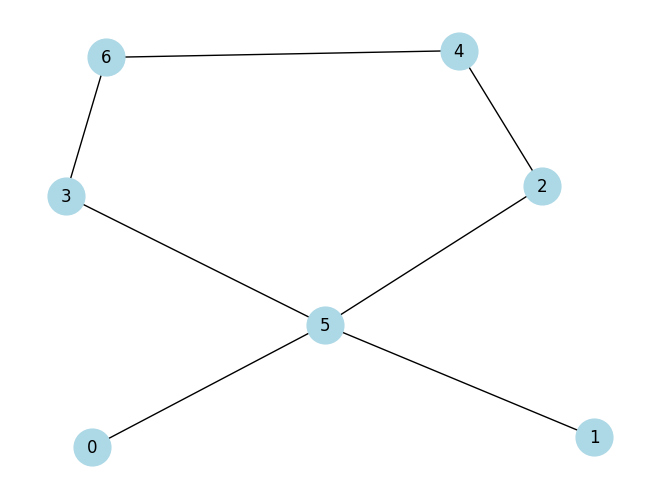

In [167]:
G = nx.erdos_renyi_graph(p=0.4,n=7,seed=20)
nx.draw(G,with_labels=True,node_color='lightblue',node_size=700)
G_mat = nx.to_numpy_array(G)
print(G_mat)
plt.draw()

In [168]:
for i in range(G_mat.shape[0]):
    dist = find_shortest_distance(G,3,i) 
    print(f"starting from {i} to {6}","\t",dist,"\n")

nx.shortest_path_length(G,3)

starting from 0 to 6 	 2 

starting from 1 to 6 	 2 

starting from 2 to 6 	 2 

starting from 3 to 6 	 0 

starting from 4 to 6 	 2 

starting from 5 to 6 	 1 

starting from 6 to 6 	 1 



{3: 0, 5: 1, 6: 1, 0: 2, 1: 2, 2: 2, 4: 2}

In [169]:
def my_closeness_centrality(G:nx.Graph):
    N = G.number_of_nodes()
    centrality = [0] * N
    for i in G.nodes():
        total_dist = 0
        for j in G.nodes():
            if i != j:
                total_dist += find_shortest_distance(G,i,j)
        if total_dist > 0:
            centrality[i] = (N-1)/total_dist

    return centrality

print(my_closeness_centrality(G))
print(nx.closeness_centrality(G)) 

[0.46153846153846156, 0.46153846153846156, 0.6, 0.6, 0.5, 0.75, 0.5]
{0: 0.46153846153846156, 1: 0.46153846153846156, 2: 0.6, 3: 0.6, 4: 0.5, 5: 0.75, 6: 0.5}


In [170]:
def my_betweenness_centrality(G: nx.Graph) -> dict[int, float]:
    nodes = list(G.nodes())
    scores: dict[int, float] = {node: 0.0 for node in nodes}

    for i in nodes:
        for j in nodes:
            for k in nodes:
                if i == j or i == k or j >= k:
                    continue

                # Find all shortest paths between j and k
                all_shortest = list(nx.all_shortest_paths(G, source=j, target=k))
                num_shortest_paths = len(all_shortest)

                if num_shortest_paths > 0:
                    paths_through_i = 0
                    for path in all_shortest:
                        if i in path[1:-1]:
                            paths_through_i += 1
                    if num_shortest_paths > 0:
                        scores[i] += paths_through_i / num_shortest_paths

    return scores

print(my_betweenness_centrality(G))
print(nx.betweenness_centrality(G, normalized=False))

{0: 0.0, 1: 0.0, 2: 3.0, 3: 3.0, 4: 1.0, 5: 10.0, 6: 1.0}
{0: 0.0, 1: 0.0, 2: 3.0, 3: 3.0, 4: 1.0, 5: 10.0, 6: 1.0}


In [171]:
#\alpha < \frac{1}{\rho(G)
def spectral_radius(A):
    vals = np.linalg.eigvals(A)
    return max(abs(vals))

rho = spectral_radius(nx.to_numpy_array(G))

alpha = np.random.uniform(0, 1/rho)
print("spectral radius:", rho)
print("chosen alpha:", alpha)

spectral radius: 2.2561897492053387
chosen alpha: 0.2258394174331972


In [172]:
import numpy as np
import networkx as nx

def my_katz_centrality(G: nx.Graph, alpha=0.85, beta=1.0, normalized=True):
    A = nx.to_numpy_array(G)
    n = A.shape[0]
    I = np.eye(n)
    ones = beta * np.ones((n, 1))

    # raw Katz vector
    r = np.linalg.solve(I - alpha*A.T, ones)

    # optional, networkx does it!
    if normalized:
        r = r / np.linalg.norm(r)  
    return r.flatten()

mine = my_katz_centrality(G, alpha=alpha)
nx_vals = nx.katz_centrality(G, alpha=alpha, beta=1.0, normalized=True)

print("mine:", mine[:5])
print("networkx:", list(nx_vals.values())[:5])

mine: [0.30548674 0.30548674 0.38686612 0.38686612 0.36034178]
networkx: [0.3054867557797557, 0.3054867557797557, 0.38686611070981275, 0.38686611070981275, 0.3603417910046729]


In [173]:
#list(G.nodes())

In [174]:
def my_page_rank(G_nx: nx.Graph, alpha: float = 0.85,tol: float = 1e-9, max_iter: int = 100):
    if not G_nx.is_directed():
        G_nx = G_nx.to_directed()

    N = G_nx.number_of_nodes()
    nodes = list(G_nx.nodes())
    A = nx.to_numpy_array(G_nx, nodelist=nodes)

    H = A.T.copy()

    C = (1 / N) * np.ones((N, N), dtype=float)
    out_degree = np.sum(A, axis=1)

    for j in range(N): 
        if out_degree[j] > 0:
            H[:,j] /= out_degree[j]  
        else:
            H[:,j] = 1.0 / N

    G = alpha * H + (1 - alpha) * C

    # eigs, vecs = np.linalg.eig(G)
    # print("Eigenvalues:", eigs)

    pi = 1/N * np.ones((N,1))
    
    for _ in range(max_iter):
        prev_pi = pi.copy()
        pi = G@pi

        if np.linalg.norm(pi - prev_pi) < tol:
            break

    s = np.sum(pi)
    if s > 0:
        return dict(zip(nodes, pi/s))
    
print(my_page_rank(G,alpha=alpha))
print(nx.pagerank(G,alpha=alpha))

{0: array([0.12169855]), 1: array([0.12169855]), 2: array([0.13775662]), 3: array([0.13775662]), 4: array([0.14220788]), 5: array([0.1966739]), 6: array([0.14220788])}
{0: 0.12169858962293632, 1: 0.12169858962293632, 2: 0.13775667173575729, 3: 0.13775667173575729, 4: 0.14220786039732922, 5: 0.1966737564879542, 6: 0.14220786039732922}


In [175]:
N=3000
p = 0.001
G = nx.erdos_renyi_graph(n=N,p=p,seed=22)

In [176]:
# \bar k = \frac{2L}{N}
def average_degree(G: nx.Graph):
    G_matrix = nx.to_numpy_array(G)
    total_degree = (np.ones((G.number_of_nodes(),1)).T @ G_matrix @ np.ones((G.number_of_nodes(),1))).item()
    return total_degree / G_matrix.shape[0]

print(average_degree(G))
print(2 * G.number_of_edges() / G.number_of_nodes())

2.9353333333333333
2.9353333333333333


In [177]:
def classify_graph_regime(G: nx.Graph):
    N = G.number_of_nodes()
    expected_degree = p * (N - 1)
    logN = np.log(N)

    if expected_degree < 1:
        print(f" Given that {expected_degree:.3f} < 1, our regime is SUBCRITICAL")
    elif abs(expected_degree - 1) < 1e-6:  # tolerance for equality
        print(f" Given that {expected_degree:.3f} ≈ 1, our regime is CRITICAL")
    elif expected_degree < logN:
        print(f" Given that 1 < {expected_degree:.3f} < log(N)={logN:.3f}, our regime is SUPERCRITICAL (sparse)")
    else:
        print(f" Given that {expected_degree:.3f} >> log(N)={logN:.3f}, our regime is DENSE")

classify_graph_regime(G)

 Given that 1 < 2.999 < log(N)=8.006, our regime is SUPERCRITICAL (sparse)


## Network Graphs

A **random network** is defined as a probability distribution over possible graphs.  
This makes it possible to specify a **probabilistic rule** for how nodes connect.  

---

### 1. Erdős–Rényi Model $G(n,p)$
- **Definition:**  
  Given $n$ nodes, each of the $\binom{n}{2}$ possible edges is included **independently** with probability $p$.  

- **Setup:**  
  The model is fully determined by the pair $(n,p)$.  
  1. Fix the number of nodes $n$.  
  2. Choose an edge probability $p \in [0,1]$.  
  3. For each possible pair of nodes, include the edge with probability $p$, independently.  

- **Key Properties:**  
  - Degree distribution: approximately **Binomial** $\text{Bin}(n-1,p)$, converging to **Poisson** in the sparse limit ($n \to \infty$, $p \to 0$, with $np=\lambda$ fixed).  
  - **No clustering beyond chance**: triangles occur only with probability $p$, without additional reinforcement.  
  - **No hubs**: degrees are concentrated around the mean $p(n-1)$; extreme degrees are rare.  
  - **Threshold phenomena**: giant component appears when $p \sim 1/n$; connectivity occurs when $p \sim (\ln n)/n$.  

---


### 2. Uniform Attachment Model (UA)

- **Definition:**  
  Start with a small initial graph (often one or two nodes). At each step:  
  1. A new node arrives.  
  2. It chooses one or more existing nodes **uniformly at random** (all existing nodes equally likely).  
  3. The new node creates exactly $m$ edges to existing nodes, choosing them according to the probability above.


- **Key Properties:**  
  - Degree distribution: **exponential**  
    $$
    P(k) \sim C e^{-\lambda k},
    $$  
    meaning high-degree nodes are exponentially rare.  
  - **No hubs**: unlike preferential attachment, UA does not produce dominant nodes with extremely high degree.  
  - **No clustering beyond chance**: triangles occur only accidentally, with probability consistent with uniform random linking.  
  - Serves as the **baseline growth model**, analogous to how Erdős–Rényi is the baseline static model.  

---

### 3. Preferential Attachment Model (Barabási–Albert)

- **Definition:**  
  The probability that a new node connects to an existing node is proportional to its degree. Formally:
  $$
  \Pr(\text{new node links to } i) = \frac{\deg(i,t)}{\sum_{j=1}^n \deg(j,t)}
  $$
  This implements the **“rich-get-richer”** rule.

- **Mechanism (Barabási–Albert):**
  1. Start with a small seed network.  
  2. At each step, a new node arrives.  
  3. The new node creates exactly $m$ edges to existing nodes, choosing them according to the probability above.

- **Key Properties:**  
  - Degree distribution follows a **power law**:
    $$
    P(k) \sim k^{-3}
    $$
  - **Hubs** naturally emerge (a few very high-degree nodes).  
  - **Low clustering** (triangles form only by chance).  
  - **Small-world property**: average path length grows logarithmically with network size.  
  - **Robustness**: resilient to random failure, fragile to targeted hub attacks.  


In [178]:
N = 7
p = 0.3


[Erdős-Rényi]
  n: 2000
  m: 4056
  avg_degree: 4.056
  max_degree: 12
  avg_clustering: 0.0018448412698412698
  giant_component_size: 1969
  diameter_giant: 12

[Uniforme (anexação aleatória)]
  n: 2000
  m: 3986
  avg_degree: 3.986
  max_degree: 16
  avg_clustering: 0.0019011363636363635
  giant_component_size: 2000
  diameter_giant: 9

[Preferencial (BA via amostragem de arestas)]
  n: 2000
  m: 3977
  avg_degree: 3.977
  max_degree: 135
  avg_clustering: 0.011578754935231373
  giant_component_size: 1995
  diameter_giant: 8

[Misto (alpha=0.5)]
  n: 2000
  m: 3982
  avg_degree: 3.982
  max_degree: 39
  avg_clustering: 0.004241867831129465
  giant_component_size: 2000
  diameter_giant: 9


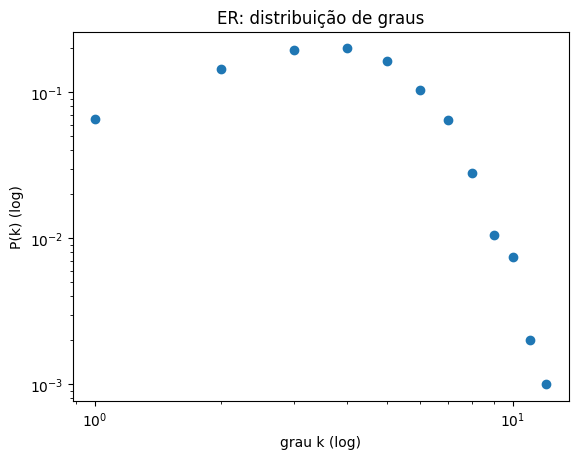

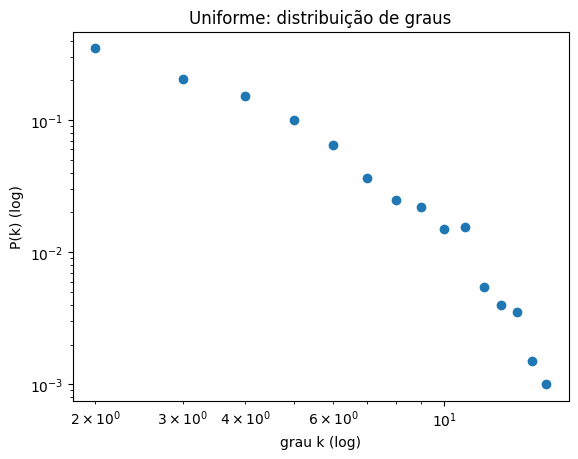

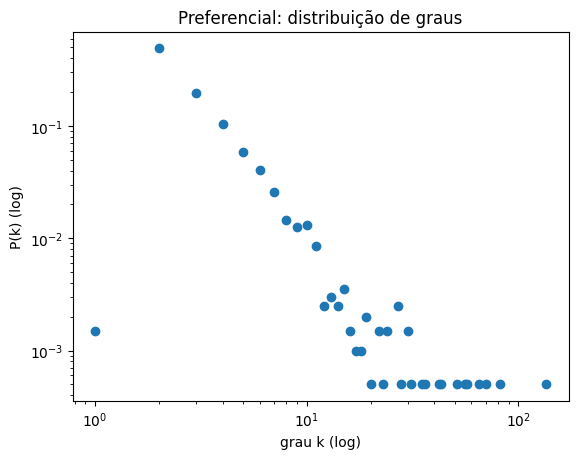

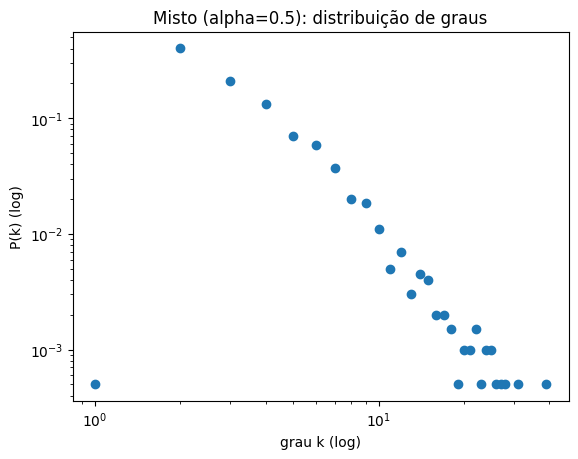

In [179]:
import numpy as np
import networkx as nx
import itertools
import matplotlib.pyplot as plt
from collections import Counter
np.random.seed(42)

def my_erdos_renyi_model(n: int, p: float):
    nodes = list(range(n))
    all_edges = list(itertools.combinations(nodes, 2))
    G = nx.Graph()
    G.add_nodes_from(nodes)
    for edge in all_edges:
        if np.random.rand() < p: 
            G.add_edge(*edge)
    return G

def my_uniform_model(n:int, p:float, num_edges:int):
    G = nx.erdos_renyi_graph(num_edges + 5, p)
    for new_node in range(num_edges+5,n):
        targets = np.random.choice(list(G.nodes()), size=num_edges, replace=False)
        G.add_node(new_node)
        for t in targets:
            G.add_edge(new_node,t)
    return G

def my_barabasi_model(n: int, p: float, num_edges: int):
    G = nx.erdos_renyi_graph(num_edges + 5, p)

    for new_node in range(num_edges + 5, n):
        if G.number_of_edges() < num_edges:
            targets = np.random.choice(list(G.nodes()), size=num_edges, replace=False)
        else:
            edges = list(G.edges())
            idx = np.random.choice(len(edges), size=num_edges, replace=False)  # amostra índices
            sampled_edges = [edges[i] for i in idx]
            targets = [e[np.random.randint(0, 2)] for e in sampled_edges]

        G.add_node(new_node)
        for t in targets:
            if t != new_node:
                G.add_edge(new_node, t)
    return G



def my_mixed_model(n:int, p:float, num_edges:int, alpha:float):
    G = nx.erdos_renyi_graph(num_edges + 5, p)

    for new_node in range(num_edges+5, n):
        if np.random.rand() > alpha:
            targets = np.random.choice(list(G.nodes()), size=num_edges, replace=False)
        else:
            if G.number_of_edges() < num_edges:
                targets = np.random.choice(list(G.nodes()), size=num_edges, replace=False)
            else:
                edges = list(G.edges())
                idx = np.random.choice(len(edges), size=num_edges, replace=False)
                sampled_edges = [edges[i] for i in idx]
                targets = [e[np.random.randint(0, 2)] for e in sampled_edges]

        G.add_node(new_node)
        for t in targets:
            if t != new_node:
                G.add_edge(new_node, t)
    return G



def basic_stats(G):
    n = G.number_of_nodes()
    m = G.number_of_edges()
    degs = [d for _, d in G.degree()]
    avg_k = np.mean(degs)
    max_k = np.max(degs) if degs else 0
    cc = nx.average_clustering(G) if n > 1 else 0.0
    comps = list(nx.connected_components(G))
    giant_size = max((len(c) for c in comps), default=0)
    diam = None
    if giant_size > 1:
        H = G.subgraph(max(comps, key=len)).copy()
        if nx.is_connected(H):
            diam = nx.diameter(H)
    return {
        "n": n, "m": m, "avg_degree": avg_k, "max_degree": max_k,
        "avg_clustering": cc, "giant_component_size": giant_size, "diameter_giant": diam
    }

def plot_degree_hist(G, title="Degree distribution (log-log)"):
    degs = [d for _, d in G.degree()]
    c = Counter(degs)
    x = np.array(sorted([k for k in c.keys() if k>0]))
    y = np.array([c[k] for k in x]) / G.number_of_nodes()
    if len(x)==0:
        print("Sem graus positivos para plotar.")
        return
    plt.figure()
    plt.loglog(x, y, marker='o', linestyle='none')
    plt.xlabel("grau k (log)")
    plt.ylabel("P(k) (log)")
    plt.title(title)
    plt.show()


n = 2000
p0 = 0.002
m_new = 2
alpha = 0.5

G_er = my_erdos_renyi_model(n, p0)
G_un = my_uniform_model(n, p0, m_new)
G_ba = my_barabasi_model(n, p0, m_new)
G_mix = my_mixed_model(n, p0, m_new, alpha)

for name, G in [("Erdős-Rényi", G_er),
                ("Uniforme (anexação aleatória)", G_un),
                ("Preferencial (BA via amostragem de arestas)", G_ba),
                (f"Misto (alpha={alpha})", G_mix)]:
    stats = basic_stats(G)
    print(f"\n[{name}]")
    for k, v in stats.items():
        print(f"  {k}: {v}")

plot_degree_hist(G_er, "ER: distribuição de graus")
plot_degree_hist(G_un, "Uniforme: distribuição de graus")
plot_degree_hist(G_ba, "Preferencial: distribuição de graus")
plot_degree_hist(G_mix, f"Misto (alpha={alpha}): distribuição de graus")


## Scale Free Distributions

### Friendship-Paradox

The degree distribution $p_k$ expresses the probability that a randomly selected node has $k$ neighbors. However, if we randomly select a link, the probability that a node at one of its ends has degree $k$ is $q_k = A k p_k$, where $A$ is a normalization factor.

**1)**

Given a network with a truncated power-law degree distribution
$$
p_k = C\,k^{-\gamma}, \qquad k_{\min} \le k \le k_{\max}, \quad 2<\gamma<3,
$$
and the excess-degree distribution
$$
q_k = A\,k\,p_k, \qquad k_{\min} \le k \le k_{\max},
$$
find the normalization factor $A$ such that
$$
\sum_{k=k_{\min}}^{k_{\max}} q_k \;=\; 1.
$$
Express $A$ explicitly in terms of $k_{\min},\,k_{\max},\,\text{and } \gamma$.

_Solution_


We know that $p_k$ is a proper distribution. Hence 
$$
\sum_{k_{min}}^{k_{max}} q_k = \sum_{k_{min}}^{k_{max}} A k p_k = A \sum_{k_{min}}^{k_{max}} k p_k = A\cdot\mathbb{E}[k]
$$
Because we want $q_k$ to be a proper distribution. Then:
$$
\sum_{k_{min}}^{k_{max}} q_k =A\cdot\mathbb{E}[p_k]  = 1 \implies A = \frac{1}{\mathbb{E}[k]} = \frac{1}{\langle k \rangle}
$$
Studying our new found discrete distribution:
$$
q_k =\frac{k\cdot p_k}{\langle k \rangle} = \frac{k\cdot C\,k^{-\gamma}}{\langle k \rangle}
$$
Right now we accomplished our goal of represential $q_k$ in terms of known constants and terms. But we can go even futher trying to pinpoint the exact functional equation of $\langle k \rangle$.

In light of this, notice that:
$$
\sum_{k_{min}}^{k_{max}} p_k = \sum_{k_{min}}^{k_{max}} C k^{-\gamma} \implies C = \left(\sum_{k_{min}}^{k_{max}} k^{-\gamma} \right)^{-1}
$$
PLugin this result into the definition of expectation and using the closed form of $p_k:$
$$
\langle k \rangle = \sum_{k_{min}}^{k_{max}} k \cdot p_k \implies \frac{1}{\langle k \rangle } =  C\cdot \left(\sum_{k_{min}}^{k_{max}} k^{1-\gamma} \right)^{-1}= \frac{\sum_{k_{min}}^{k_{max}} k^{-\gamma}}{\sum_{k_{min}}^{k_{max}} k^{1-\gamma} }
$$
We can go a step further and approximate the summation using integration:
$$
\int_{k_{min}}^{k_{max}} k^{1-\gamma}\,dk
$$
Using oru hypothesis, we know that $\gamma>2$, making our integral converge, taking the asymototic limit $k_{max}\to\infty$, we have a standard polynomial integral:
$$
\int_{k_{min}}^{+\infty} k^{1-\gamma}\,dk = \frac{1}{(2-\gamma)} k_{min}^{2-\gamma},\quad \int_{k_{min}}^{+\infty} k^{-\gamma}\,dk = \frac{1}{(1-\gamma)}k_{min}^{1-\gamma}
$$
Hence:
$$
\frac{1}{\langle k \rangle } = \frac{1}{\frac{(1-\gamma)}{(2-\gamma)}k_{\min}}
$$

**2)**

In the configuration model, $q_k$ is the probability that a randomly chosen node has a neighbor with degree $k$. What is the average degree of the neighbors of a randomly chosen node?  

_Solution_
We know that by definition the degree distribution of the neighbour is given by $q_k$. Hence, its expectation can be calculated as follows:
$$
\sum_{k_{min}}^{k_{max}} k q_k = \sum_{k_{min}}^{k_{max}} k\cdot \left(\frac{k\cdot p_k}{\langle k\rangle}\right) = \frac{\langle k\rangle^2}{\langle k\rangle}
$$